<a href="https://colab.research.google.com/github/RachelRamirez/misclassification_matrix/blob/main/PreExperiment_PA_Shfl_40D_Lambda1_Lambda2_Lambda3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreExperiment PA Shfl 40D Lambda1 Lambda2 Lambda3




In prior notebooks, I experimented with one variable; lambda, the value the cost-matrix takes on for whatever misclassification we are interested in.  The seeded neural network we trained using a normal cost-matrix of all ones usually had a higher misclassification count on the **T**rue 9s being mislabelled by the model **P**redicting 4s, which you will sometimes see written as "9T, 4P" and "w[9t,4p]" when referring to the cost of the misclassification.

We changed the lambda values and allowed as many epochs of training with  early-stopping and a patience of 10 to conclude once training was beginnnig to overfit the validation data (also the test set).   Lambda values chosen were 1, 10, 100, and 1000.   These values were chosen because it seemed that only very high values like 1000 could drive down the number of misclassifications of 9T,4P to zero.

In this notebook, continuing to use a relatively balanced dataset, we're going to also experiment with a second variable, time of training.  This is a little more tricky to define because the variable lambda is thought to have an impact on the number of epochs needed.  Therefore if you have a certain lambda value in the beginning of training, you may only need 10 total epochs of training, but if you use it at the end of training, you may need more epochs of training.  In addition there is the question as to whether we should define   a static number of epochs or to allow early stopping.  

As an example:


|Lambda | Rep 1 Epochs | Rep 2 Epochs |  Rep 3 | Rep 4 |	Rep 5 |	Rep 6	| Rep 7	| Rep 8	|Rep 9	| Rep 10 |  Average of 10 Reps |
|-- | -- | --- |  --| -- |  --| -- |  --| -- |  --| -- |  --| 
1	|17|19|19|	22|	17	|21	|19	|22	|19|	22|	... 19*
100 |14|14|14|	11|	14	|14	|14	|14	|14|	14|	... 13.7*
1000:	|18|23|22|	35|	7	|25	|21	|19	|23|	24|	... 21.7

*However 1 and 100 were done with patience of 3, whereas 1000 was done with patience of 10 and more epochs.  Rerunning the 1's with the same patience appears to up the number of epochs til early stopping to mid-20s.  


We'll test the conditions for using a static training cycle first, because it's easier to code and report on, and then test how to do a dynamic training cycle, 


## Reduced  capacity neural network with two layers of 40 connections

  Filename "PA_Shfl_w[9,4]_2.0_40D_Misclassification_Cost_Matrix_Example"

#### Check timezone if incorrect restart

In [ ]:
# How to change the local time in Google Colab
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/US/Eastern /etc/localtime
!date

#If this doesn't show the local time correctly, then you need to restart.
import time
time.localtime(time.time())

Thu 09 Mar 2023 08:30:52 AM EST


time.struct_time(tm_year=2023, tm_mon=3, tm_mday=9, tm_hour=8, tm_min=30, tm_sec=52, tm_wday=3, tm_yday=68, tm_isdst=0)

### Reproducible Seeds

In [ ]:
#For Reproducibility
import numpy as np
# np.random.seed(1337)  # for reproducibility

import tensorflow as tf
# tf.random.set_seed(33)

import random as python_random
# python_random.seed(4)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
tf.keras.utils.set_random_seed(342) #Possibly use next iteration if the above doesn't work


# Running more than once causes variation.  try adding this:
# Set seed value
seed_value = 56
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

print("TF version: " , tf.__version__ )
print("Keras version: " , tf.keras.__version__ )

TF version:  2.11.0
Keras version:  2.11.0


### Import rest of Library

In [ ]:

# from https://github.com/keras-team/keras/issues/2115#issuecomment-204060456
# witha correction on the weighted function in the middle 

'''Train a simple deep NN on the MNIST dataset.
Get to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function  #do i still need this?
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K
from itertools import product
import functools
from functools import partial
from time import ctime
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix

## MORE REPEATABILITY STUFF NEEDED - If theres a way to update this to V2 of Tensorflow great, otherwise I had to use TF 1.0 code
# 5. Configure a new global `tensorflow` session (https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds)
# from keras import backend as K


#I believe thecode below is to help things be repeatable each time different sections in my google colab notebook execute
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
# I do this initial download to start with so Colab doesn't wait until a run is done to ask if it can download
import pickle 
variable_to_be_deleted = np.array((1,10))
file_name = "delete_later.pkl"

with open(file_name, 'wb') as handle:
      
    # A new file will be created
    pickle.dump(variable_to_be_deleted, handle,  protocol=pickle.HIGHEST_PROTOCOL)

from google.colab import files
files.download( file_name )  

print(file_name, " was saved to Downloads ")

del(variable_to_be_deleted)
del(file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

delete_later.pkl  was saved to Downloads 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Con3"

path = "/content/drive/MyDrive/Con3/"
 

import pickle 
variable_to_be_deleted = np.array((1,10))
file_name = "delete_later.pkl"

with open(path + file_name, 'wb') as handle:
      
    # A new file will be created
    pickle.dump(variable_to_be_deleted, handle,  protocol=pickle.HIGHEST_PROTOCOL)

# from google.colab import files
# files.download( file_name )  

print(file_name, " was saved to Google MyDrive ")


import os
try:
    os.remove(path+file_name)
    print(file_name, " was deleted from Google MyDrive ")

except:
    print("Error while deleting file : ", path+file_name)

delete_later.pkl  was saved to Google MyDrive 


### Define batch, epochs, and format data

In [ ]:
batch_size = 256 # I originally had it very  high batch size to reduce the variation in the data each batch and hope it makes the model training more nearly identical which it did, then i bring it back down to something reasonable to get better results training the NN
nb_classes = 10
nb_epoch = 45

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
# print(X_train.shape[0], 'train samples')
# print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#Create a Validation Set
X_val = X_test[:7500]   #take the first 7500 for validation
Y_val = Y_test[:7500]   #Take the first 7500 for validation
y_val = y_test[:7500]

X_test = X_test[7500:]  #Keep the last 2500 for test/holdout
Y_test = Y_test[7500:]  #Keep the last 2500 for test/holdout
y_test = y_test[7500:]

print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

#Are the sets relatively balanced? Yes each category is between 8% and 11% per category
Y_train.sum(axis=0)/X_train.shape[0]
Y_val.sum(axis=0)/X_val.shape[0]
Y_test.sum(axis=0)/X_test.shape[0]

60000 train samples
7500 validation samples
2500 test samples


array([0.1044, 0.1144, 0.0992, 0.102 , 0.0932, 0.0864, 0.1008, 0.1064,
       0.0972, 0.096 ], dtype=float32)

### Weighted Categorical Cross Entropy Class

In [ ]:
class WeightedCategoricalCrossentropy(tf.keras.losses.CategoricalCrossentropy):

  def __init__(self, cost_mat, name='weighted_categorical_crossentropy', **kwargs):

    cost_mat = np.array(cost_mat)   
    ## when loading from config, self.cost_mat returns as a list, rather than an numpy array. 
    ## Adding the above line fixes this issue, enabling .ndim to call sucessfully. 
    ## However, this is probably not the best implementation
    assert(cost_mat.ndim == 2)
    assert(cost_mat.shape[0] == cost_mat.shape[1])
    super().__init__(name=name, **kwargs)
    self.cost_mat = K.cast_to_floatx(cost_mat)

  def __call__(self, y_true, y_pred, sample_weight=None):
    assert sample_weight is None, "should only be derived from the cost matrix"  
    return super().__call__(
        y_true=y_true, 
        y_pred=y_pred, 
        sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
    )


  def get_config(self):
    config = super().get_config().copy()
    # Calling .update on the line above, during assignment, causes an error with config becoming None-type.
    config.update({'cost_mat': (self.cost_mat)})
    return config

  @classmethod
  def from_config(cls, config):
    # something goes wrong here and changes self.cost_mat to a list variable.
    # See above for temporary fix
    return cls(**config)

def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    assert(y_pred.shape[1] == num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n


# Register the loss in the Keras namespace to enable loading of the custom object.
tf.keras.losses.WeightedCategoricalCrossentropy = WeightedCategoricalCrossentropy
 

### Train Model with WeightedCategoricalCross Entropy Function 

In [ ]:
def PA_method_epoch(model3, lambda_val, nb_epoch = 5, patience = 5 , **args):
  # print("Parameter values specified for this training-cycle.  Number of epochs: ", nb_epoch, "Number of epochs of Patience: ", patience)
  cost_matrix = np.ones((10,10))

  Truth=9
  Predicted=4

  cost_matrix[Truth, Predicted] = lambda_val
  # print("The cost of a true ", str(Truth), "  predicted as a ", str(Predicted), " is ", lambda_val  )


  # ---------------------------------------------------------------------------------------------------------------------------------
  # Is a Model already created?  
  # ---------------------------------------------------------------------------------------------------------------------------------
  if model3==None:  #"No model was passed through so one will be initiated")

      print("No model was passed through so one will be initiated")

      model3 = Sequential()
      model3.add(Dense(40, input_shape=(784,), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
      model3.add(Activation('relu'))
      model3.add(Dropout(0.2))
      model3.add(Dense(40, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
      model3.add(Activation('relu'))
      model3.add(Dropout(0.2))
      model3.add(Dense(10,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
      model3.add(Activation('softmax'))
      rms = RMSprop()  #https://keras.io/api/optimizers/rmsprop/
      model3.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=rms,  metrics='categorical_accuracy',)

 
  # else:  #A model was passed through, so no other model will be created
  #   # print("A model was passed through")


  def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    y_prediction3 = model3.predict(X_val, verbose=0)     #I call it y_prediction3 because I just want to make sure this is  updated within and not interfering with the other prediction below
    y_prediction3  = np.argmax(y_prediction3, axis=1)

    #Create confusion matrix 
    cm = confusion_matrix(y_val, y_prediction3)
    cm_array = np.asarray(cm)  #Indiv CM as array for storing
    logs['9T_4P'] = cm[9,4]
    logs['4T_9P'] = cm[4,9]
    logs['cm_per_epoch'] = cm_array.reshape((1,100))
  # Define the per-epoch callback.
  cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix, )


  # ---------------------------------------------------------------------------------------------------------------------------------
  # Will this be a training session with early-stopping? If so user specifies a patience level, and the appropriate callback is used
  # ---------------------------------------------------------------------------------------------------------------------------------
  if patience > 0:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)
    model3_history = model3.fit(X_train, Y_train,
          batch_size=batch_size, epochs=nb_epoch, verbose=0,
          validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True
          ,callbacks = [es_callback, cm_callback]
          )
  #If early-stopping is not needed then the model will be trained without using the ES callback
  else:  # no need to do early-stopping if patience = 0
    model3_history = model3.fit(X_train, Y_train,
          batch_size=batch_size, epochs=nb_epoch, verbose=0,
          validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True
          ,callbacks = [cm_callback]    #<<< -------------- the only thing that changed is no EarlyStop Callback
          )

 

    
  # ---------------------------------------------------------------------------------------------------------------------------------
  # Training complete.  Make Predictions
  # ---------------------------------------------------------------------------------------------------------------------------------
  #Predict
  y_prediction = model3.predict(X_val, verbose=0)
  y_prediction  = np.argmax(y_prediction, axis=1)
  # Y_prediction = np_utils.to_categorical(y_prediction, nb_classes)

  #Create confusion matrix and normalizes it over predicted (columns)
  # result = confusion_matrix(y_val, y_prediction , normalize='pred')



  cm3 = confusion_matrix(y_val, y_prediction)
  cm3 = pd.DataFrame(cm3, range(10),range(10))
  
  # plt.figure(figsize = (10,10))
  # cm3
  # sns.heatmap(cm2, annot=True, annot_kws={"size": 12}) # font size
  # plt.show()
  # cm_using_weighted_new = cm3

  # print(model3_history.history)
  tot_epochs = max(model3_history.epoch)+1  #if the total epochs ran is 28, it'll show up as 27 in the epoch object so we must add 1
  print("Total Epochs: ", tot_epochs)

  #if tot_epochs is the total number of epochs ran then early stop did not happen, and we need not minus patience
  if tot_epochs == nb_epoch:
    restored_weights = tot_epochs
  else:
    restored_weights  = tot_epochs-patience   #when using restore-best-weights and patience, it'll restore the best weights back
  print("Restored weights at ", restored_weights, "Patience used: ", patience)


  return cm3, model3_history, model3, restored_weights


#### Single Plot Function

In [ ]:
def plot_fx(model3_history, restored_weights):


  tot_epochs = max(model3_history.epoch)+1

  #Label is the epoch weights are restored 
  label = f"{restored_weights}"
  #Label_vale is the value at which the epoch weights are restored 
  label_value = f"{ model3_history.history['val_categorical_accuracy'][restored_weights-1]}"
  print("Label: ", label, "Val_Cat_Acc Value: ", label_value)



  plt.plot(range(1,tot_epochs+1), model3_history.history['categorical_accuracy'],)
  plt.plot(range(1,tot_epochs+1), model3_history.history['val_categorical_accuracy'])
  plt.xlim(xmin=1)

  plt.scatter((restored_weights), model3_history.history['val_categorical_accuracy'][restored_weights-1] , color='orange')

  plt.annotate(text=label,  xy=(restored_weights, model3_history.history['val_categorical_accuracy'][restored_weights-1]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch (starts at 1)')

  
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  

  plt.plot(range(1,tot_epochs+1), model3_history.history['loss'])
  plt.plot(range(1,tot_epochs+1), model3_history.history['val_loss'])
  plt.xlim(xmin=1)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch (starts at 1)')
  plt.legend(['train', 'val'], loc='upper left')
  plt.scatter(restored_weights, model3_history.history['val_loss'][restored_weights-1], color='orange')
  plt.annotate(text=label,  xy=(restored_weights, model3_history.history['val_loss'][restored_weights-1]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')
  plt.show()


#### Plot all three phases together

In [ ]:
def plot_3_fx(model1_history, model2_history, model3_history, restored_weights1, restored_weights2, restored_weights3):
  
  tot_epochs = restored_weights1 + restored_weights2 + restored_weights3

  #Label is the epoch weights are restored 
  label1 = f"{restored_weights1}"
  #Label_vale is the value at which the epoch weights are restored 
  label_value1 = f"{ model1_history.history['val_categorical_accuracy'][restored_weights1-1]}"
  # print("Label1: ", label1, "Val_Cat_Acc Value1: ", label_value1)


  #Label is the epoch weights are restored in the second phase of training
  # if restoredweights are 5 then it'll be after the max number of epochs of the first models training 
  label2 = f"{restored_weights2}"
  #Label_vale is the value at which the epoch weights are restored 
  label_value2 = f"{ model2_history.history['val_categorical_accuracy'][restored_weights2-1]}"
  # print("Label2: ", label2, "Val_Cat_Acc Value2: ", label_value2)

  #Label is the epoch weights are restored in the second phase of training
  # if restoredweights are 5 then it'll be after the max number of epochs of the first models training 
  label3 = f"{restored_weights3}"
  #Label_vale is the value at which the epoch weights are restored 
  label_value3 = f"{ model3_history.history['val_categorical_accuracy'][restored_weights3-1]}"
  # print("Label3: ", label3, "Val_Cat_Acc Value3: ", label_value3)

 
  
  epochs = [restored_weights1, restored_weights2, restored_weights3]
  models = [history1, history2, history3]

  grab_n_epochs_of_model_metric_fun = lambda epoch, model, metric: model.history[metric][:epoch]

  model_total_cat_acc =     np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['categorical_accuracy']*3)), axis=0)
  model_total_val_cat_acc = np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['val_categorical_accuracy']*3)), axis=0)
  
  model_total_loss =        np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['loss']*3)), axis=0)
  model_total_val_loss =    np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['val_loss']*3)), axis=0)

  model_total_val_9T_4P =   np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['9T_4P']*3)), axis=0)
  model_total_val_4T_9P =   np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['4T_9P']*3)), axis=0)

  
  #ScatterPlotPoint and Annotate RestoredWeights1 
  offsets = [0,restored_weights1, restored_weights1+restored_weights2]
  labels = [label1, label2, label3]

  for metric in list(('val_categorical_accuracy', 'val_loss', '9T_4P')):


    if(metric=='val_categorical_accuracy'):
      plt.plot(range(1,tot_epochs+1), model_total_cat_acc)
      plt.plot(range(1,tot_epochs+1), model_total_val_cat_acc)
    elif(metric=='val_loss'):
      plt.plot(range(1,tot_epochs+1), model_total_loss)
      plt.plot(range(1,tot_epochs+1), model_total_val_loss)
    else:
      plt.plot(range(1,tot_epochs+1), model_total_val_9T_4P, color='orange')
      plt.plot(range(1,tot_epochs+1), model_total_val_4T_9P, color='orange', linestyle='dashed')

    plt.xlim(xmin=0)


    for epoch, model, offset, label in zip(epochs, models, offsets, labels):
      # print(f'Epoch of Restored-Weights: {epoch}, Model: {model}, Offset: {offset}')
      plt.scatter((epoch+offset), model.history[metric][epoch-1] , color='orange')
      plt.annotate(text=label,  xy=((epoch+offset), model.history[metric][epoch-1]),
                  textcoords="offset points", 
                  xytext=(0,10), 
                  ha='center')
    
    if(metric=='val_categorical_accuracy'):
      plt.ylabel('accuracy')
      plt.title('model accuracy')
      plt.legend(['train', 'val'], loc='lower right')
    

    elif(metric=='val_loss'):
      plt.ylabel('loss')
      plt.title('model loss')
      plt.legend(['train', 'val'], loc='upper right')

    else:
      plt.ylabel('count')
      plt.title('Validation misclassifications of 9T as 4P and reverse')
      plt.legend(['9t_4p', '4t_9p'], loc='upper right')
    

    plt.xlabel('epoch (starts at 1)') 
    
    plt.show()


    history =   {'categorical_accuracy': model_total_cat_acc , 
               'val_categorical_accuracy': model_total_val_cat_acc  , 
              'loss': model_total_loss,
               'val_loss': model_total_val_loss ,   
               '9T_4P': model_total_val_9T_4P ,  
               '4T_9P': model_total_val_4T_9P}
 


  return history
 


### *Keep Track of Experimental Admin Stuff - #Reps and #CostMatrix

> Change the cost matrix and number of reps and check the file extension name 


#### *Define Cost Matrix and Method

In [ ]:
# Experimental Admin Stuff

# # ### Weight of Misclassifications for three stages of training
# lambda1, lambda2, lambda3 = 1, 1, 1


# # ### Number of Epochs for each Stage of Training
# train_epochs1, train_epochs2, train_epochs3 = 5, 5, 20

# # ### Whether there is EarlyStopping and if so how many Epochs of Patience Patience=0 means no EarlyStopping
# es1, es2, es3 = 5, 5, 20

# # ### String of weights-of-misclassification for naming files
# ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
# cost_str = str(lambda1) + "_" + str(lambda2) + "_"  + str(lambda3)
# epochs_str = str(train_epochs1) + "_" + str(train_epochs2) + "_"  + str(train_epochs3)
# patience_str = str(es1) + "_" + str(es2) + "_"  + str(es3)
# # ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

 

# ### File Extension to reference in JMP : weights_method_costs1_2_3
# ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# file_extension = "w[9,4]_L_" + cost_str + "_E_" + epochs_str + "_P_" + patience_str + "_"
# ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# print(len(file_extension))


# np.set_printoptions(suppress=True)
# np.set_printoptions(precision=2)

# print("Last run using ", cost_str)
# print("File Extension ", file_extension)

#### Run Experiments

     | --- Init --- | | --- Mid --- | | --- Late --- | 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

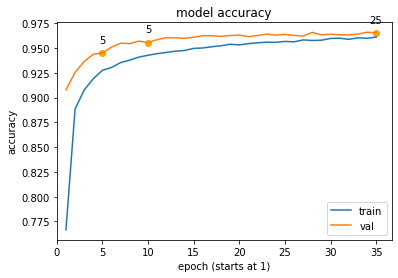

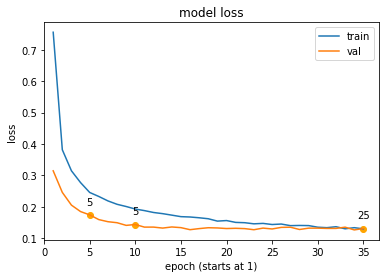

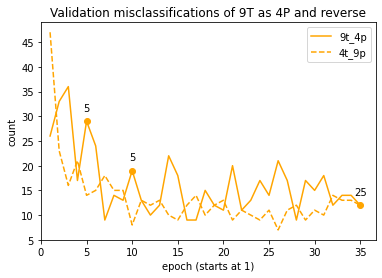

Run:  1  Rep:  1   complete 

time: 0832
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run1_rep_1_w[9,4]_L_1_1_1_E_5_5_25_P_0_0_25__2023_03_09_0832_.pkl  was saved to Downloads 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

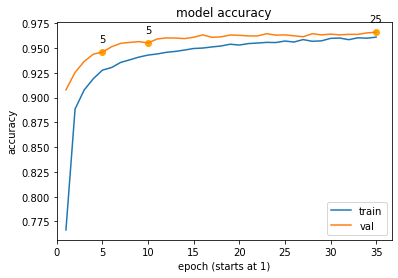

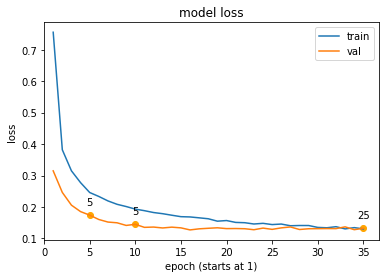

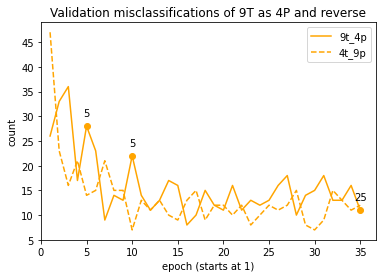

Run:  1  Rep:  2   complete 

time: 0833
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run1_rep_1_w[9,4]_L_1_1_1_E_5_5_25_P_0_0_25__2023_03_09_0833_.pkl  was saved to Downloads 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

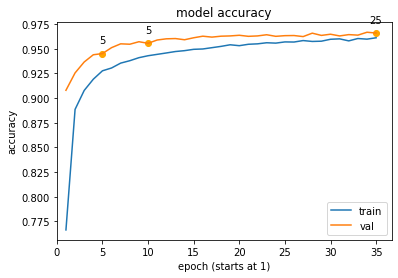

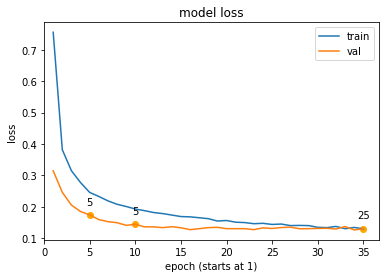

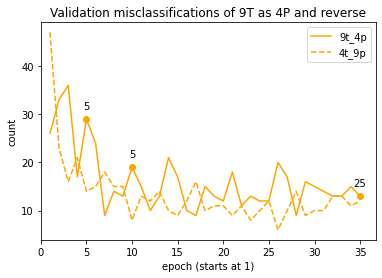

Run:  1  Rep:  3   complete 

time: 0834
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run1_rep_1_w[9,4]_L_1_1_1_E_5_5_25_P_0_0_25__2023_03_09_0834_.pkl  was saved to Downloads 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

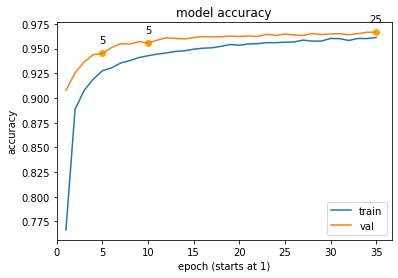

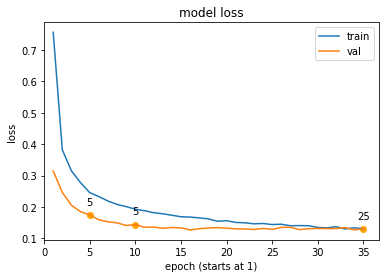

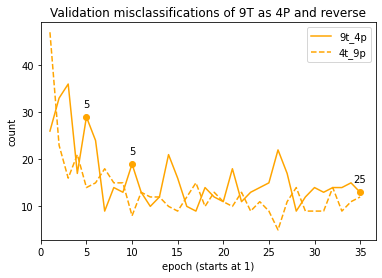

Run:  1  Rep:  4   complete 

time: 0835
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run1_rep_1_w[9,4]_L_1_1_1_E_5_5_25_P_0_0_25__2023_03_09_0835_.pkl  was saved to Downloads 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

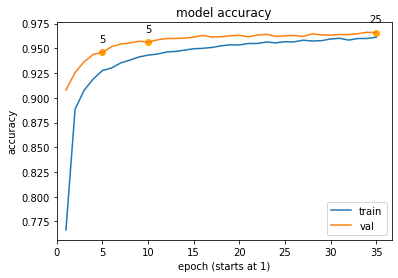

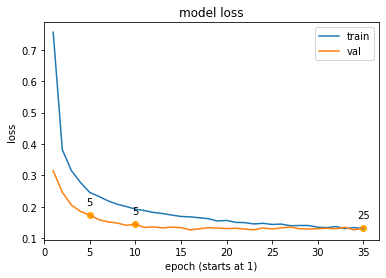

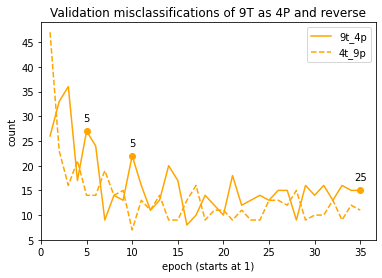

Run:  1  Rep:  5   complete 

time: 0836
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run1_rep_1_w[9,4]_L_1_1_1_E_5_5_25_P_0_0_25__2023_03_09_0836_.pkl  was saved to Downloads 
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

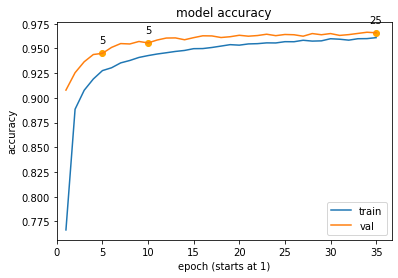

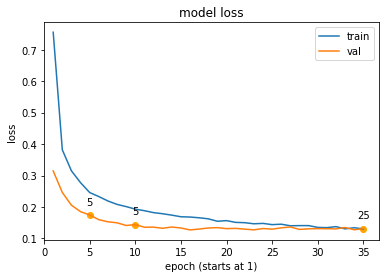

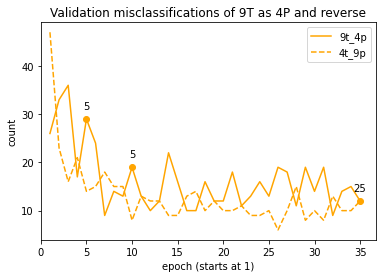

Run:  2  Rep:  1   complete 

time: 0837
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run2_rep_2_w[9,4]_L_1_1_100_E_5_5_25_P_0_0_25__2023_03_09_0837_.pkl  was saved to Downloads 
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

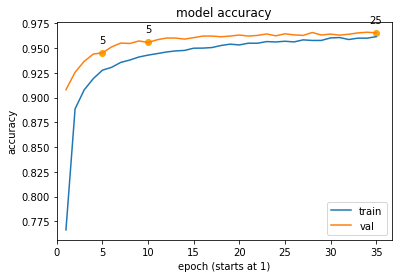

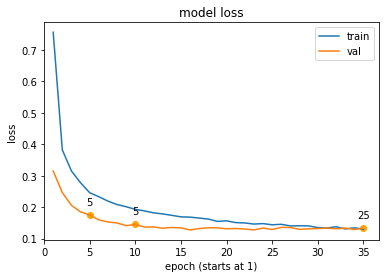

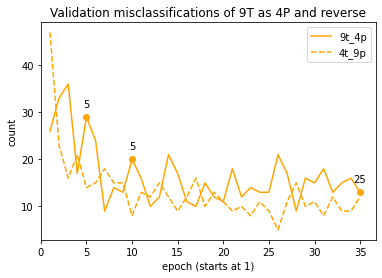

Run:  2  Rep:  2   complete 

time: 0838
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run2_rep_2_w[9,4]_L_1_1_100_E_5_5_25_P_0_0_25__2023_03_09_0838_.pkl  was saved to Downloads 
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

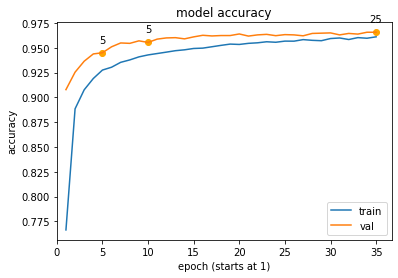

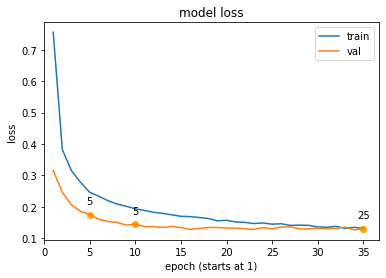

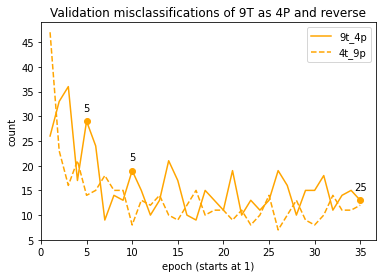

Run:  2  Rep:  3   complete 

time: 0839
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run2_rep_2_w[9,4]_L_1_1_100_E_5_5_25_P_0_0_25__2023_03_09_0839_.pkl  was saved to Downloads 
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

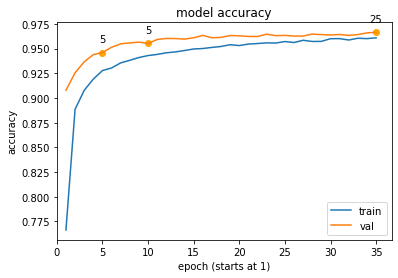

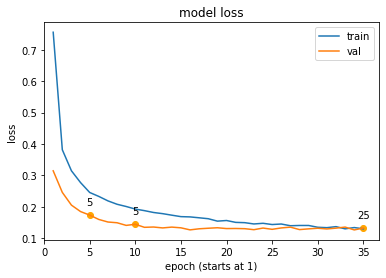

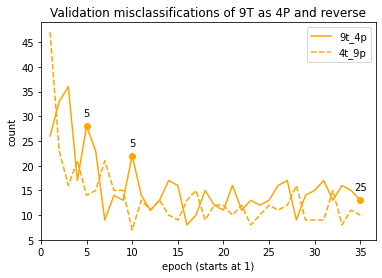

Run:  2  Rep:  4   complete 

time: 0840
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run2_rep_2_w[9,4]_L_1_1_100_E_5_5_25_P_0_0_25__2023_03_09_0840_.pkl  was saved to Downloads 
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

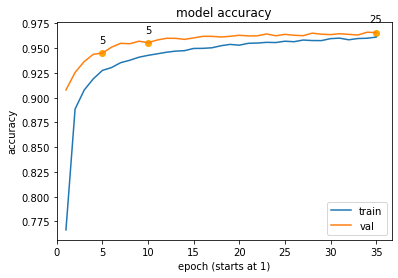

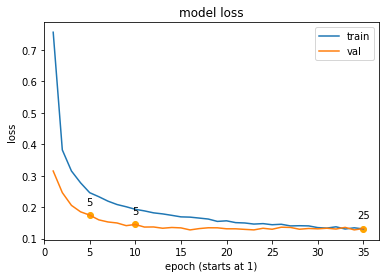

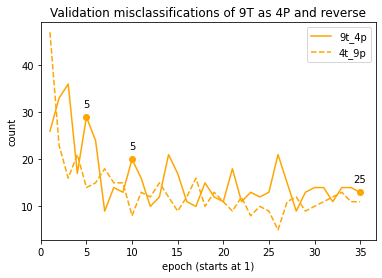

Run:  2  Rep:  5   complete 

time: 0841
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run2_rep_2_w[9,4]_L_1_1_100_E_5_5_25_P_0_0_25__2023_03_09_0841_.pkl  was saved to Downloads 
3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

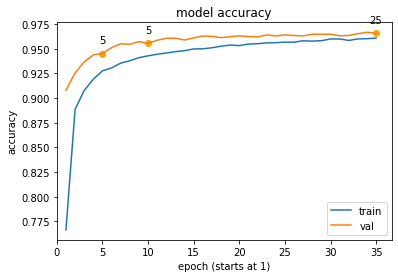

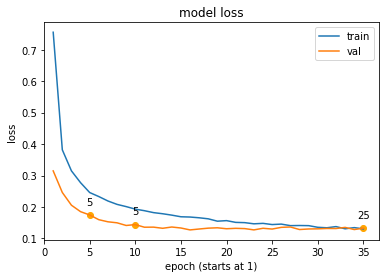

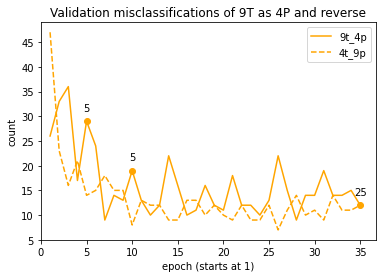

Run:  3  Rep:  1   complete 

time: 0842
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run3_rep_3_w[9,4]_L_1_1_1000_E_5_5_25_P_0_0_25__2023_03_09_0842_.pkl  was saved to Downloads 
3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

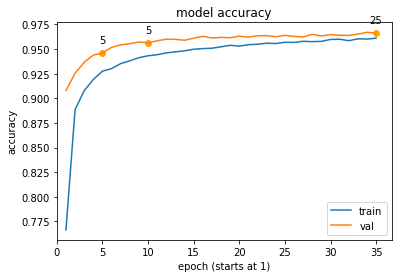

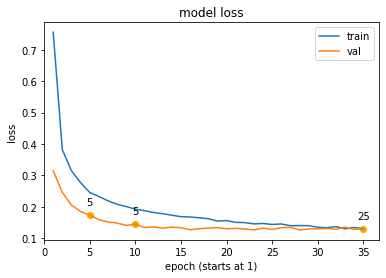

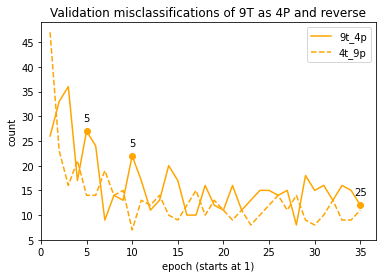

Run:  3  Rep:  2   complete 

time: 0843
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run3_rep_3_w[9,4]_L_1_1_1000_E_5_5_25_P_0_0_25__2023_03_09_0843_.pkl  was saved to Downloads 
3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

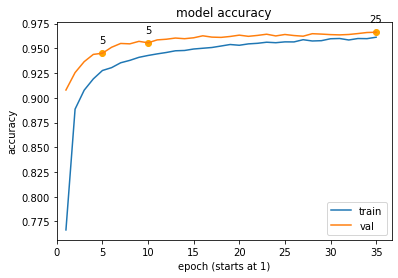

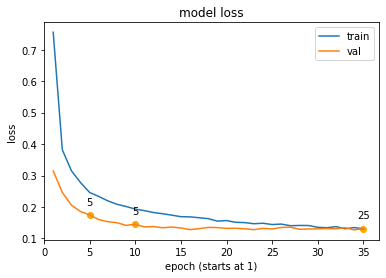

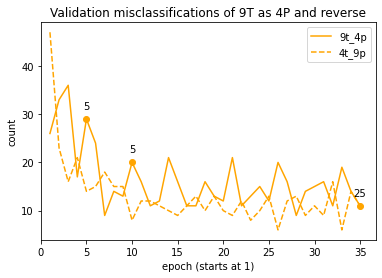

Run:  3  Rep:  3   complete 

time: 0844
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run3_rep_3_w[9,4]_L_1_1_1000_E_5_5_25_P_0_0_25__2023_03_09_0844_.pkl  was saved to Downloads 
3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

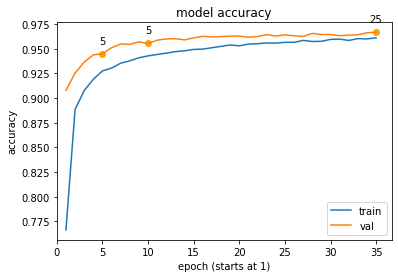

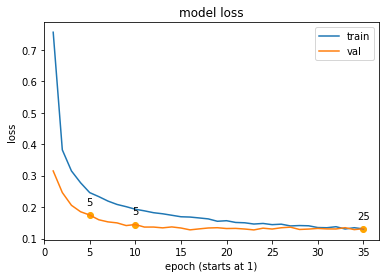

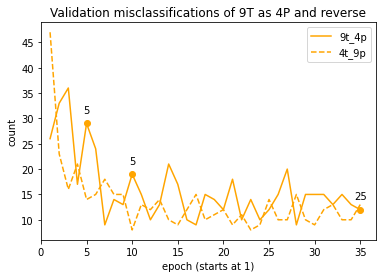

Run:  3  Rep:  4   complete 

time: 0845
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run3_rep_3_w[9,4]_L_1_1_1000_E_5_5_25_P_0_0_25__2023_03_09_0845_.pkl  was saved to Downloads 
3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

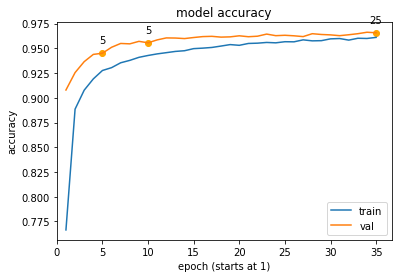

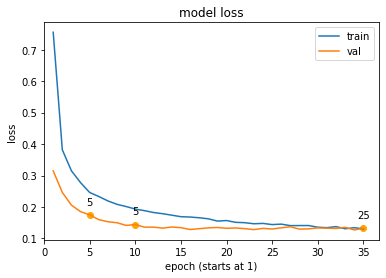

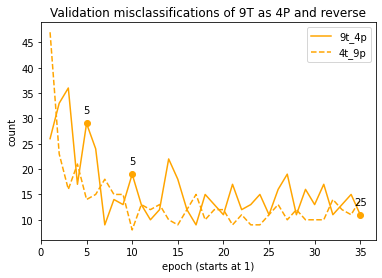

Run:  3  Rep:  5   complete 

time: 0846
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run3_rep_3_w[9,4]_L_1_1_1000_E_5_5_25_P_0_0_25__2023_03_09_0846_.pkl  was saved to Downloads 
4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

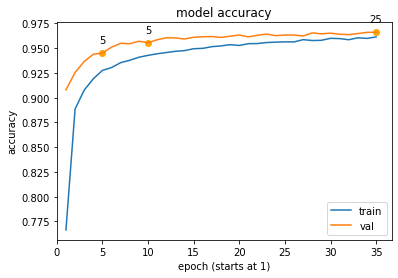

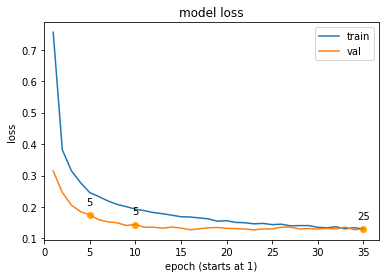

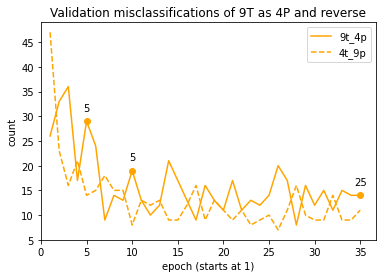

Run:  4  Rep:  1   complete 

time: 0847
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run4_rep_4_w[9,4]_L_1_100_1_E_5_5_25_P_0_0_25__2023_03_09_0847_.pkl  was saved to Downloads 
4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

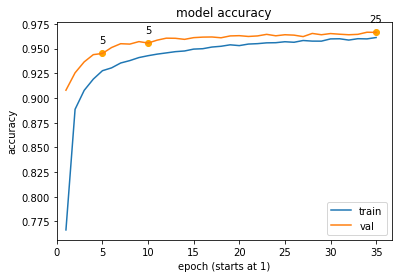

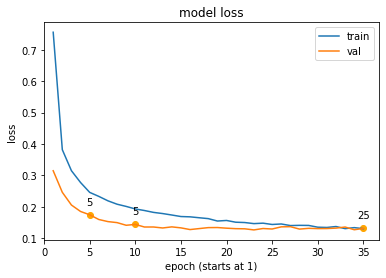

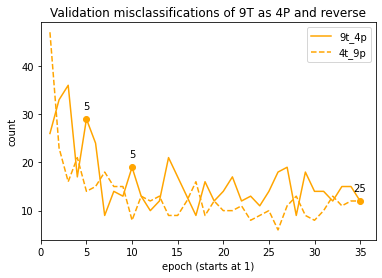

Run:  4  Rep:  2   complete 

time: 0848
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run4_rep_4_w[9,4]_L_1_100_1_E_5_5_25_P_0_0_25__2023_03_09_0848_.pkl  was saved to Downloads 
4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

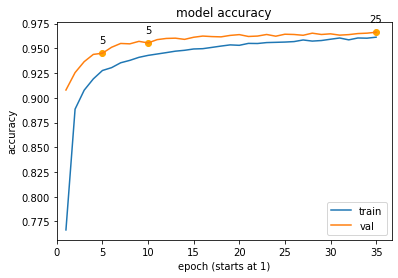

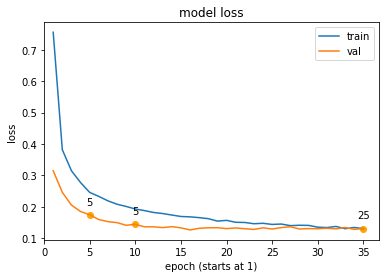

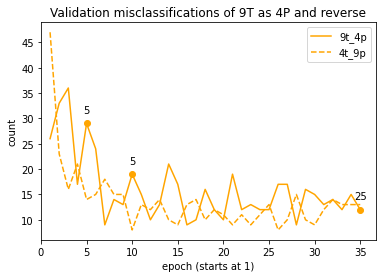

Run:  4  Rep:  3   complete 

time: 0849
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run4_rep_4_w[9,4]_L_1_100_1_E_5_5_25_P_0_0_25__2023_03_09_0849_.pkl  was saved to Downloads 
4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

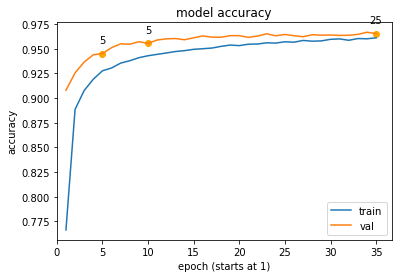

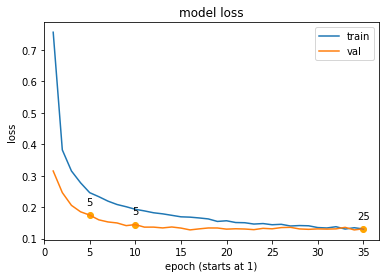

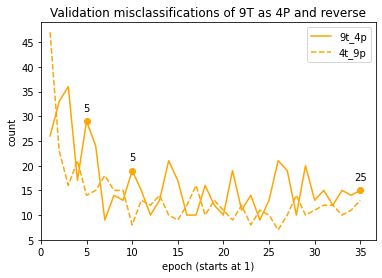

Run:  4  Rep:  4   complete 

time: 0850
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run4_rep_4_w[9,4]_L_1_100_1_E_5_5_25_P_0_0_25__2023_03_09_0850_.pkl  was saved to Downloads 
4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

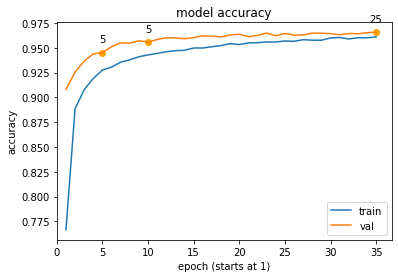

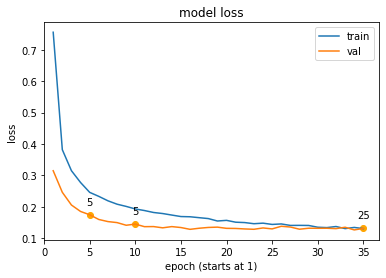

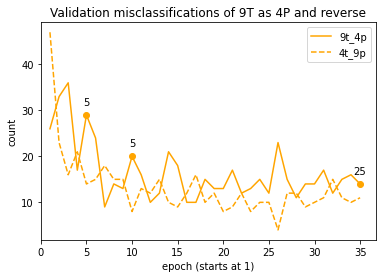

Run:  4  Rep:  5   complete 

time: 0851
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run4_rep_4_w[9,4]_L_1_100_1_E_5_5_25_P_0_0_25__2023_03_09_0851_.pkl  was saved to Downloads 
5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5

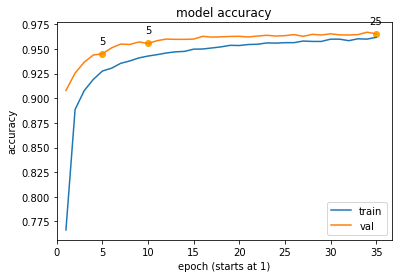

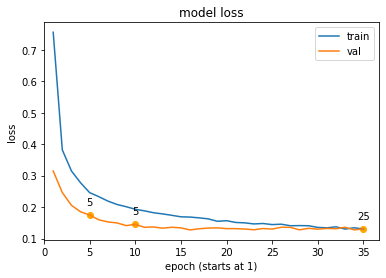

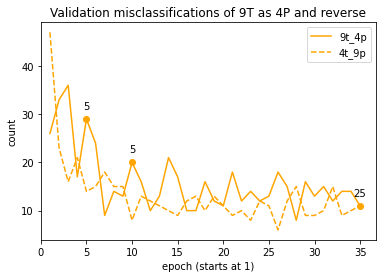

Run:  5  Rep:  1   complete 

time: 0852
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run5_rep_5_w[9,4]_L_1_100_100_E_5_5_25_P_0_0_25__2023_03_09_0852_.pkl  was saved to Downloads 
5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5

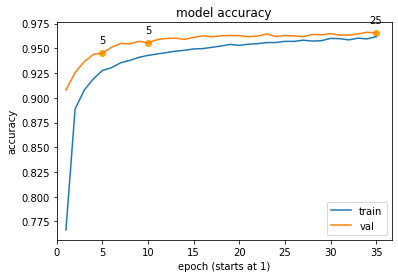

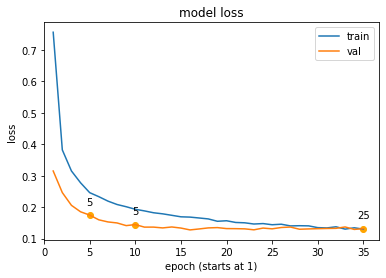

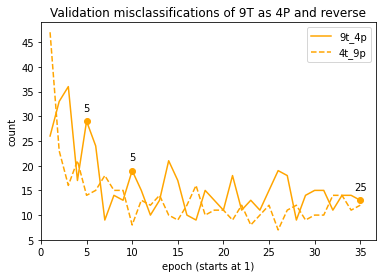

Run:  5  Rep:  2   complete 

time: 0853
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run5_rep_5_w[9,4]_L_1_100_100_E_5_5_25_P_0_0_25__2023_03_09_0853_.pkl  was saved to Downloads 
5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5

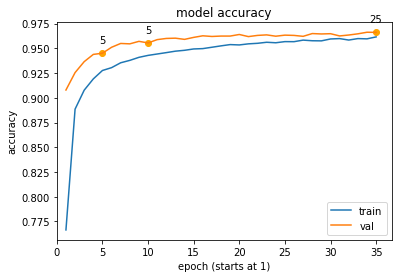

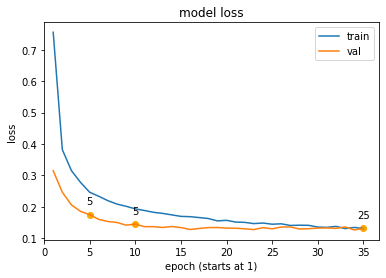

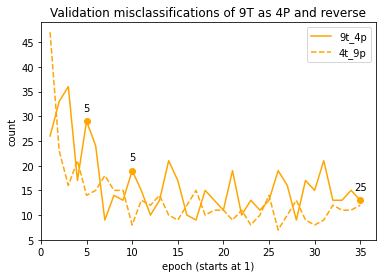

Run:  5  Rep:  3   complete 

time: 0854
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run5_rep_5_w[9,4]_L_1_100_100_E_5_5_25_P_0_0_25__2023_03_09_0854_.pkl  was saved to Downloads 
5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5

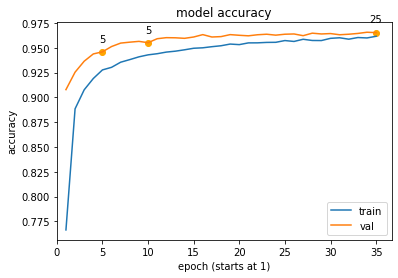

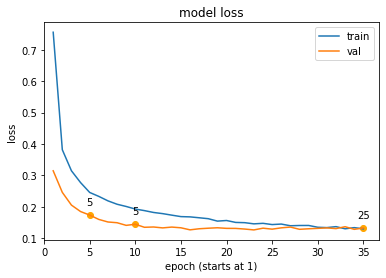

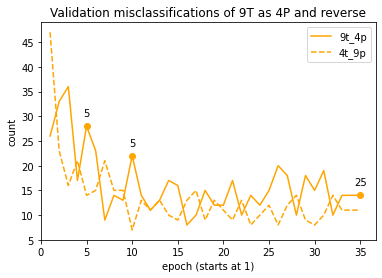

Run:  5  Rep:  4   complete 

time: 0855
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run5_rep_5_w[9,4]_L_1_100_100_E_5_5_25_P_0_0_25__2023_03_09_0855_.pkl  was saved to Downloads 
5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5

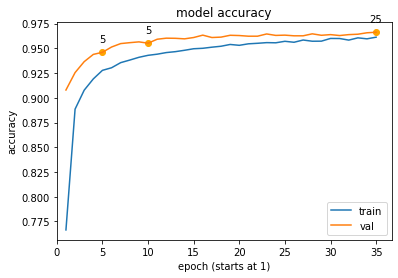

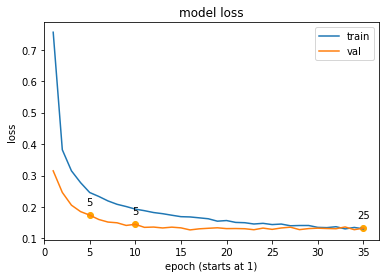

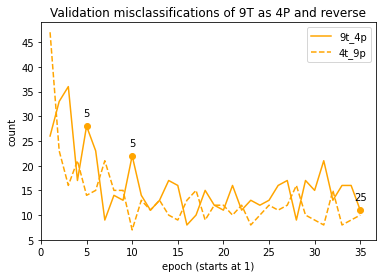

Run:  5  Rep:  5   complete 

time: 0856
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run5_rep_5_w[9,4]_L_1_100_100_E_5_5_25_P_0_0_25__2023_03_09_0856_.pkl  was saved to Downloads 
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6

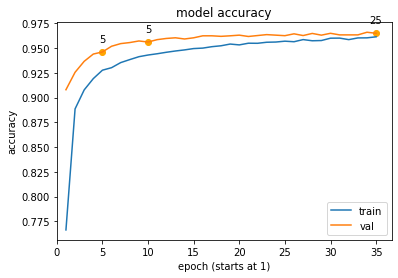

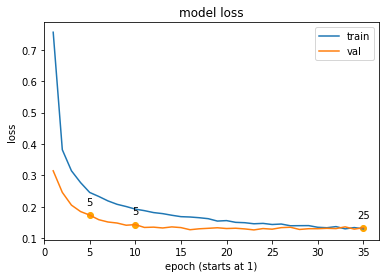

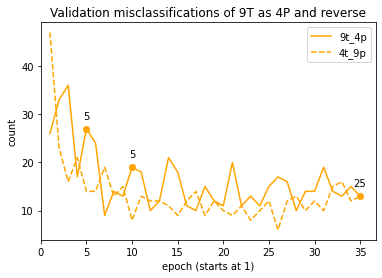

Run:  6  Rep:  1   complete 

time: 0857
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run6_rep_6_w[9,4]_L_1_100_1000_E_5_5_25_P_0_0_25__2023_03_09_0857_.pkl  was saved to Downloads 
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

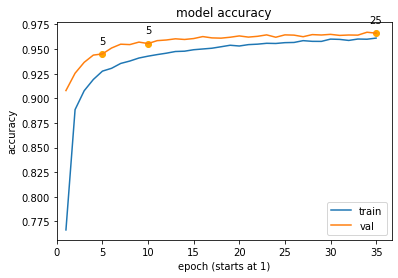

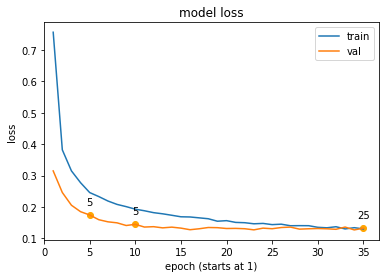

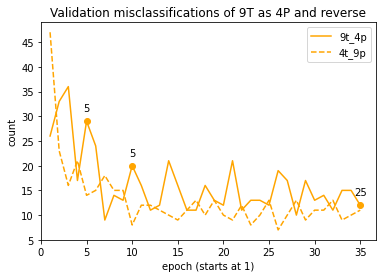

Run:  6  Rep:  2   complete 

time: 0858
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run6_rep_6_w[9,4]_L_1_100_1000_E_5_5_25_P_0_0_25__2023_03_09_0858_.pkl  was saved to Downloads 
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

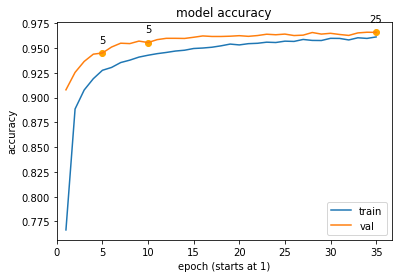

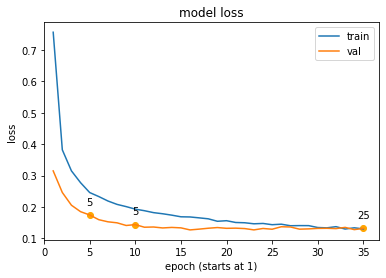

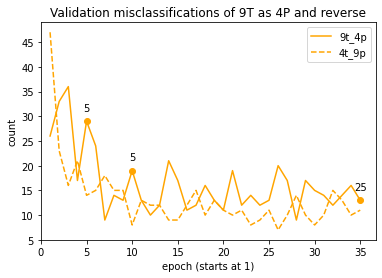

Run:  6  Rep:  3   complete 

time: 0859
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run6_rep_6_w[9,4]_L_1_100_1000_E_5_5_25_P_0_0_25__2023_03_09_0859_.pkl  was saved to Downloads 
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

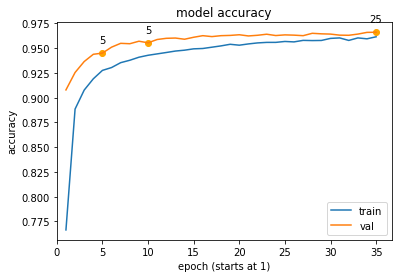

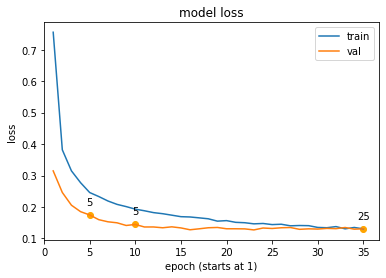

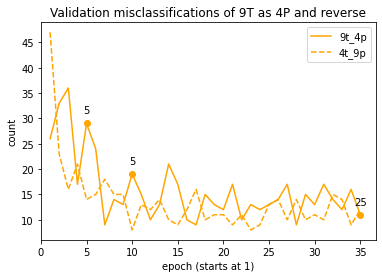

Run:  6  Rep:  4   complete 

time: 0900
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run6_rep_6_w[9,4]_L_1_100_1000_E_5_5_25_P_0_0_25__2023_03_09_0900_.pkl  was saved to Downloads 
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

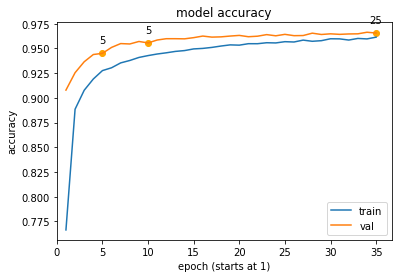

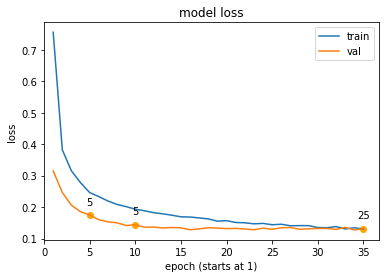

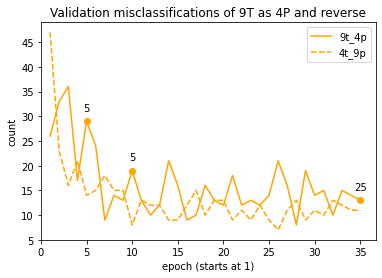

Run:  6  Rep:  5   complete 

time: 0901
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run6_rep_6_w[9,4]_L_1_100_1000_E_5_5_25_P_0_0_25__2023_03_09_0901_.pkl  was saved to Downloads 
7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 

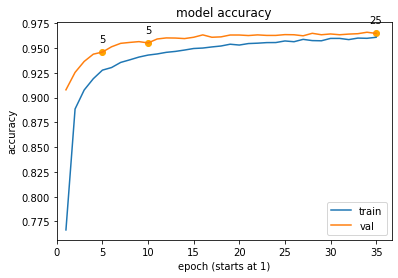

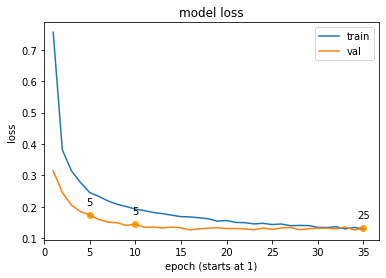

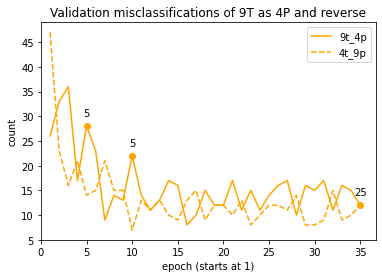

Run:  7  Rep:  1   complete 

time: 0902
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run7_rep_7_w[9,4]_L_1_1000_1_E_5_5_25_P_0_0_25__2023_03_09_0902_.pkl  was saved to Downloads 
7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 

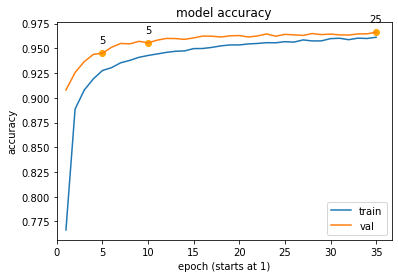

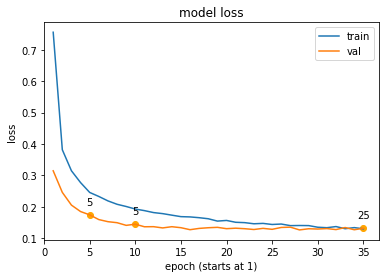

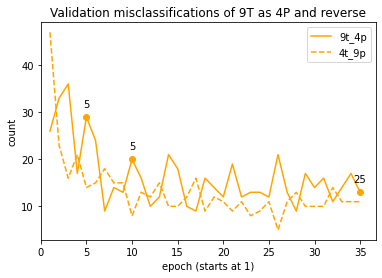

Run:  7  Rep:  2   complete 

time: 0903
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run7_rep_7_w[9,4]_L_1_1000_1_E_5_5_25_P_0_0_25__2023_03_09_0903_.pkl  was saved to Downloads 
7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 

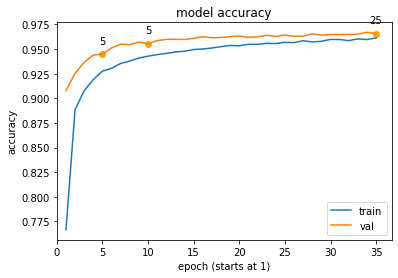

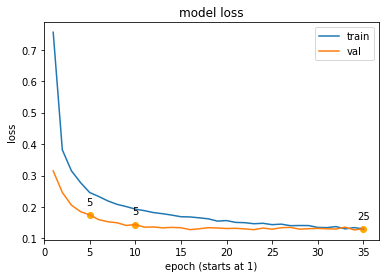

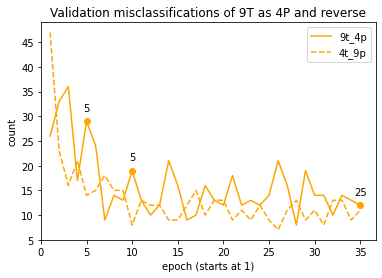

Run:  7  Rep:  3   complete 

time: 0904
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run7_rep_7_w[9,4]_L_1_1000_1_E_5_5_25_P_0_0_25__2023_03_09_0904_.pkl  was saved to Downloads 
7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 

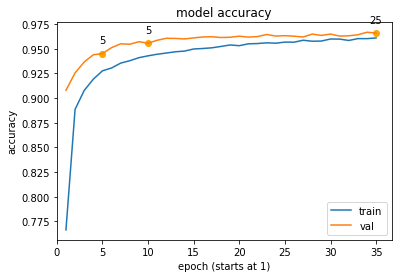

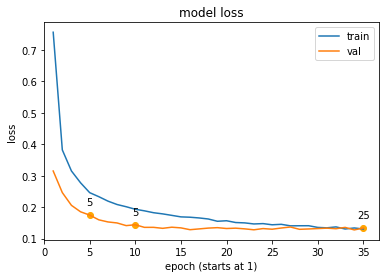

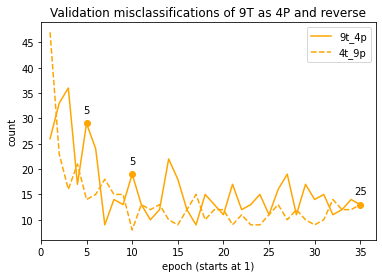

Run:  7  Rep:  4   complete 

time: 0905
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run7_rep_7_w[9,4]_L_1_1000_1_E_5_5_25_P_0_0_25__2023_03_09_0905_.pkl  was saved to Downloads 
7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 

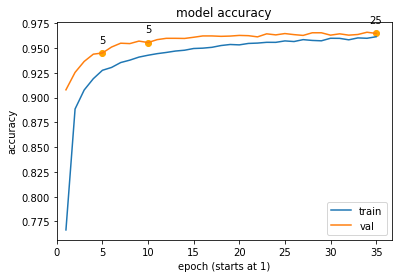

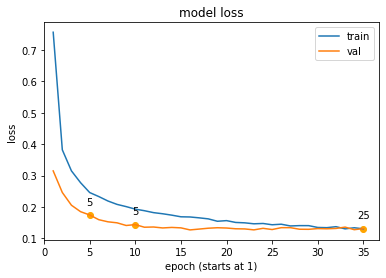

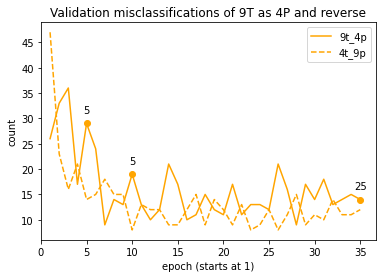

Run:  7  Rep:  5   complete 

time: 0906
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run7_rep_7_w[9,4]_L_1_1000_1_E_5_5_25_P_0_0_25__2023_03_09_0906_.pkl  was saved to Downloads 
8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

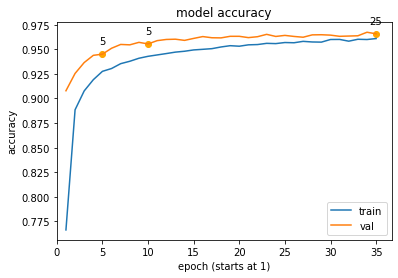

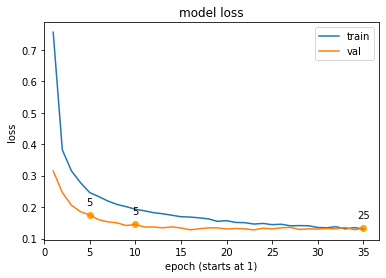

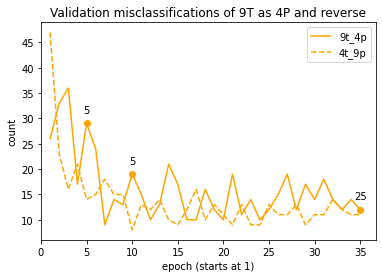

Run:  8  Rep:  1   complete 

time: 0907
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run8_rep_8_w[9,4]_L_1_1000_100_E_5_5_25_P_0_0_25__2023_03_09_0907_.pkl  was saved to Downloads 
8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

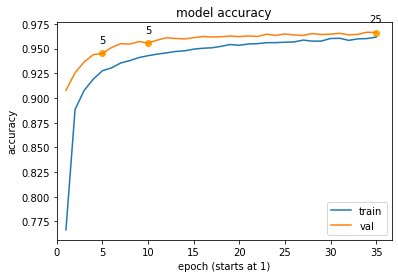

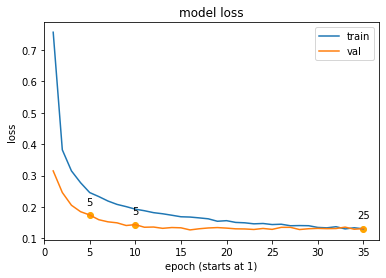

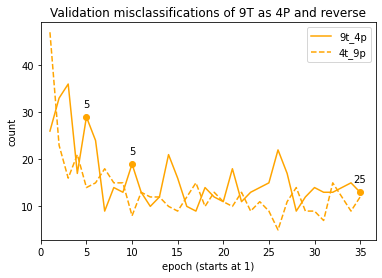

Run:  8  Rep:  2   complete 

time: 0908
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run8_rep_8_w[9,4]_L_1_1000_100_E_5_5_25_P_0_0_25__2023_03_09_0908_.pkl  was saved to Downloads 
8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

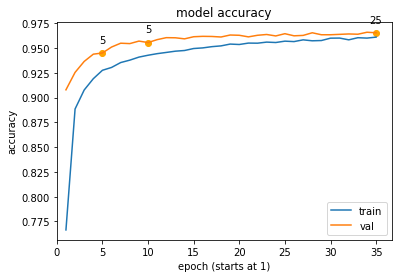

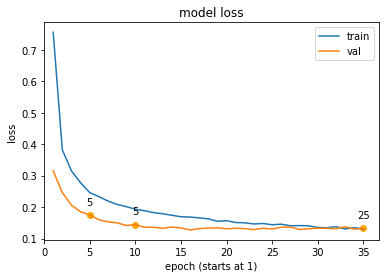

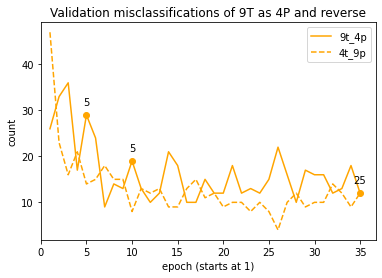

Run:  8  Rep:  3   complete 

time: 0909
False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

run8_rep_8_w[9,4]_L_1_1000_100_E_5_5_25_P_0_0_25__2023_03_09_0909_.pkl  was saved to Downloads 
8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

In [ ]:
#@title
# cm = np.zeros([10,10])
# combined_cms = np.empty((1,100))
count = 0
run = 0
rep = 0
reps = 5
print("     | --- Init --- | | --- Mid --- | | --- Late --- | ")
for i in [1, 100, 1000]: #lambda1
  for j in [1, 100, 1000]:  #lambda2
    for k in   [1, 100, 1000]: #lambda3
      run+=1
      for rep in range(1,reps+1):
        count+=1
        lambda1 = i
        lambda2 =j
        lambda3 = k


        # ### Weight of Misclassifications for three stages of training
        # lambda1, lambda2, lambda3 = 1, 1, 1


        # ### Number of Epochs for each Stage of Training
        train_epochs1, train_epochs2, train_epochs3 = 5, 5, 25

        # ### Whether there is EarlyStopping and if so how many Epochs of Patience Patience=0 means no EarlyStopping
        es1, es2, es3 = 0, 0, 25

        # ### String of weights-of-misclassification for naming files
        ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
        cost_str = str(lambda1) + "_" + str(lambda2) + "_"  + str(lambda3)
        epochs_str = str(train_epochs1) + "_" + str(train_epochs2) + "_"  + str(train_epochs3)
        patience_str = str(es1) + "_" + str(es2) + "_"  + str(es3)
        # ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

        

        ### File Extension to reference in JMP : weights_method_costs1_2_3
        ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        file_extension = "w[9,4]_L_" + cost_str + "_E_" + epochs_str + "_P_" + patience_str + "_"
        ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # print(len(file_extension))


        np.set_printoptions(suppress=True)
        np.set_printoptions(precision=2)

        # print("Last run using ", cost_str, "File Extension ", file_extension)
        print(f'{run} '*500)
        print(f"Count:{count}--Run:{run}--Rep:{rep}|Lambdas {i}, {j},{k} | Epochs: {train_epochs1} with {es1} , {train_epochs2} with {es2},  {train_epochs3} with {es3} | ")
        print(f'{run} '*500)

        combined_history_dictionary = {}  #because there will be a unknown number of epochs a dictionary is probly a better fit
        combined_cms       = {}



        def display_cm_after_training(training, cm):
          print("After ", str(training), " stage CM: \n", cm)
          print("CM[9,4]: ", cm[4][9]) #yes this is the right format dont change! [First Value is the Column][Second Value is the Row]
 

        # Initial Training _________________________________________________________
        cm1, history1, model1, restored_weights1 =  PA_method_epoch(None, lambda1, nb_epoch=train_epochs1, patience=es1 )    #Individual CM, and Training/Validation History
        # plot_fx(history1, restored_weights1)
        # display_cm_after_training("first", cm1)

        # Second Phase Training ______________________________________________________
        print("Run ", run, "Rep ", rep, "second-phase training with a  cost_matrix[9, 4] = ",  lambda2)
        cm2, history2, model2, restored_weights2 =  PA_method_epoch(model1, lambda2, nb_epoch=train_epochs2, patience=es2 )    #Individual CM, and Training/Validation History
        # plot_fx(history2, restored_weights2)
        # display_cm_after_training("second", cm2)

        
        # Third Phase Training ____________________________________________________________
        print("Run ", run, "Rep ",rep, "third-phase training with a  cost_matrix[9, 4] = ",  lambda3)
        cm3, history3, model3, restored_weights3 =  PA_method_epoch(model2, lambda3, nb_epoch=train_epochs3, patience=es3 )    #Individual CM, and Training/Validation History
        # plot_fx(history3, restored_weights3)
        # display_cm_after_training("third", cm3)
        


        # # Save the results of 1st 2nd and 3rd phase training in one combined_history_list or disctionary
        #   combined_history_dictionary[run, i] = {"First": history1, "Second": history2, "Third": history3}
        #   combined_history_list.extend((history1, history2, history3))
        cm1_array = np.asarray(cm1)  #Indiv CM as array for storing
        cm2_array = np.asarray(cm2)
        cm3_array = np.asarray(cm3)

        # This results in saving the three confusion matrices after the three stages of training
        # The shape of the combined Cms will be 1x300 so that all can be saved on one-row
      
        cms = np.vstack((cm1_array.reshape((1,100)),
                                  cm2_array.reshape((1,100)),
                                  cm3_array.reshape((1,100)))
                                )
        

        combined_history_4 = plot_3_fx(history1, history2, history3, restored_weights1, restored_weights2, restored_weights3)
        combined_history_dictionary[run, rep] = {"First": history1, "Second": history2, "Third": history3, 'Combined': combined_history_4, '3ConfusionMatrices': cms}
        combined_cms[run, rep] = cms

        print("Run: ", run, " Rep: ", rep, "  complete \n")

                    
        # To access the dictionary values for all three stages of training:
        for phase2 in ["First", "Second", "Third"]:
            # print(combined_history_dictionary[run,rep][i].history.keys())
            del combined_history_dictionary[run,rep][phase2].model #https://github.com/keras-team/keras/issues/646 from FChollet


        import pickle

        str_reps = str(rep)


        from datetime import date
        from datetime import datetime
        today = date.today()
        file_date = today.strftime("%Y_%m_%d")
        now = datetime.now() # current date and time
        file_time = now.strftime("%H%M")
        print("time:", file_time)

        str_runs = str(run)


        file_name =  "run" + str_runs + "_" + "rep_" + str_runs + "_" + file_extension + "_" + file_date + "_" + file_time +  "_.pkl"
        # print(file_name, " will be saved with ", combined_cms.shape)

        with open(file_name, 'wb') as handle:
              
            # A new file will be created
            pickle.dump(combined_history_dictionary, handle,  protocol=pickle.HIGHEST_PROTOCOL)


        # Open the file in binary mode
        with open(file_name, 'rb') as handle:
              
            # Call load method to deserialze
            unpickled_object = pickle.load(handle)
          
            print(unpickled_object == combined_history_dictionary)
            
        # print(file_name, " was opened with ", var.shape)

        from google.colab import files
        files.download( file_name )  

        print(file_name, " was saved to Downloads ")




# 

In [ ]:
# How many categories are there in the test set?

truth_num_per_category = Y_val.sum(axis=0)
print(truth_num_per_category)

Load Results

I have a lot of pickle files.  Let's see if I can load them all up and put in a csv format.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Con3"

path = "/content/drive/MyDrive/Con3/"

# #Example of Saving X by pickling into X.pickle
# pickle_out = open(path + filename, "wb")
# pickle.dump(X, pickle_out)
# pickle_out.close()
 

In [ ]:
#Save a file to myDrive/con3

# Analyze 

I am now going to load the Average CM and try to get it in a format where I can make it a 1x100 and load all 30 CMs so that we can visualize their distributions in a a big histogram_matrix. At this point the Google Colab variables are gone and I have to reoad them 

In [ ]:
# import numpy as np
# import pandas as pd
# empty_cm = np.zeros((10,10))  
# empty_cm=pd.DataFrame(empty_cm)

# empty_cm.columns = ['0p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p']
# empty_cm.index = ['0t', '1t', '2t', '3t', '4t', '5t', '6t', '7t', '8t', '9t']

# # print(myvar_cm_average)

# empty_cm_array = np.asarray(empty_cm)
# empty_cm_array_1_100 = np.reshape(empty_cm_array,(1,100))
# # print(cm_average_array)

# df = empty_cm
# df_new = pd.DataFrame(empty_cm_array_1_100,  columns=pd.MultiIndex.from_product([ df.index,df.columns]))
# df_new.columns.to_flat_index()
# df_new.columns   = ['_'.join(col) for col in df_new.columns.values]

# # Now convert combined_cms of size 30x100 to a panda dataframe
# cms_df = pd.DataFrame(combined_cms, columns=[df_new.columns], index=["First", "Second", "Third"])

# cms_df

# for run in runs:
#   for rep in reps:
#     for phase in phases:
#       pd.DataFrame(combined_history_dictionary[run,rep]["3ConfusionMatrices"], columns=[df_new.columns], index=["First", "Second", "Third"])

In [ ]:
# combined_cms[0,]

In [ ]:
# combined_cms_df["9t_4p"]

In [ ]:
# np.average(combined_cms_df["9t_4p"])

In [ ]:
# csv_filename = file_name[:-4] + ".csv"

# combined_cms_df.to_csv(csv_filename)
# # 

# from google.colab import files
# files.download(csv_filename )

# print("Downloading ", csv_filename , " of shape ", combined_cms_df.shape)

In [ ]:
# df = pd.DataFrame(sum(var)/len(var), columns=["Values"]) 
# # print(df)

# df.style.format({
#   'Values': lambda val: f'{val:,.2f}',
# })

# (df.sort_values(by="Values", ascending=False)[0:20])


# df_sorted = df.sort_values(by="Values", ascending=False)[10:]  #the top 10 are usually diagonal


# df_sorted.style.format({
#   'Values': lambda val: f'{val:,.2f}',
# })

# import math

# print("On average...")
# print("Num 1 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[0])/10), " as a ", df_sorted["Values"].index[0]%10, "  (", (df_sorted["Values"].values[0]), " times)" )
# print("Num 2 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[1])/10), " as a ", df_sorted["Values"].index[1]%10, "  (", (df_sorted["Values"].values[1]), " times)" )
# print("Num 3 misclassifications are misclassifying a ", math.floor((df_sorted["Values"].index[2])/10), " as a ", df_sorted["Values"].index[2]%10, "  (", (df_sorted["Values"].values[2]), " times)" )




In [ ]:
# df_percents = pd.DataFrame( ((sum(var)*100/len(var)).reshape((10,10))/truth_num_per_category).reshape((100)), columns = ["Values"])


# df_sorted_percents = df_percents.sort_values(by="Values", ascending=False)[10:]  #the top 10 are usually diagonal

# df_sorted_percents.style.format({
#   'Values': lambda val: f'{val:,.2f}',
# })

# print("On average .. ")
# print("Num 1 percent misclassifications", math.floor((df_sorted_percents["Values"].index[0])/10), " as ", df_sorted_percents["Values"].index[0]%10, (df_sorted_percents["Values"].values[0]), " percent" )
# print("Num 2 percent misclassifications", math.floor((df_sorted_percents["Values"].index[1])/10), " as ", df_sorted_percents["Values"].index[1]%10,  (df_sorted_percents["Values"].values[1]), " percent" )
# print("Num 3 percent misclassifications", math.floor((df_sorted_percents["Values"].index[2])/10), " as ", df_sorted_percents["Values"].index[2]%10, (df_sorted_percents["Values"].values[2]), " percent" )






# Extraneous

To reference later: 

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb#scrollTo=UJ589fn8ST3x

To train a model with class weights:

```
class_weight = {0: weight_for_0, 1: weight_for_1}

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),

    # The class weights go here
    class_weight=class_weight)
```



In [ ]:
# Extraneous information I am not using at the moment

# model.compile(
#      optimizer='adam',
#      loss=WeightedCategoricalCrossentropy(cost_matrix)
#      )

## Model Saving

# model.save(save_version_dir,save_format='tf')

## Model Loading

# model = tf.keras.models.load_model(
#     save_version_dir,
#     compile=True,
#     custom_objects={
#         'WeightedCategoricalCrossentropy': WeightedCategoricalCrossentropy(cost_matrix)
#         }
#     )
 

starting to think about how i would shape the initial, middle and late training experiments.  

In [ ]:
count = 0
run = 0
rep = 0

print("     | --- Init --- | | --- Mid --- | | --- Late --- | ")
for i in ["   1"," 100", "1000"]: #lambda1
  
  for j in  ["   1"," 100", "1000"]:  #lambda2
    for k in   ["   1"," 100", "1000"]: #lambda3
      run+=1
      for rep in range(1,30+1):
        count+=1
        print(f"{count}--{run}--{rep}    |     {i}     ,     {j}    ,    {k}     | ")
        

